In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import os
import json
import math
import torch
import numpy
import pandas
import logging
import pandas as pd
import numpy as np
from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset, load_kddcup_dataset
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
def adjust_predicts(score, label, percent=None,
                    threshold=None,
                    pred=None,
                    calc_latency=False, verbose=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.

    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is higher than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):

    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        if percent is not None:
            threshold = np.percentile(score, percent)
            if verbose:
                print("Threshold for {} percent is: {:.2f}".format(percent, threshold))
            predict = score > threshold
            if verbose:
                print("{:.3f}% is anomaly".format(100 * predict.sum()/len(predict)))
        elif threshold is not None:
            predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

    
def get_windows(ts, labels=None, dim=None, window_size=128, stride=None):
    if stride is None:
        stride = window_size
    i = 0
    ts_len = ts.shape[0]
    windows = []
    label_windows = []
    while i+window_size < ts_len:
        if dim is not None:
            windows.append(ts[i : i + window_size, dim])
        else:
            windows.append(ts[i : i + window_size])
        if labels is not None:
            label_windows.append(labels[i : i + window_size])
        i += stride
    if labels is not None:
        return np.array(windows), np.array(label_windows)
    else:
        return np.array(windows)
        

In [4]:
# datasets/anomaly/SMD/processed/machine-1-1_test.pkl
nrows=None
dataset = "SMD_1-1"

if dataset.lower().startswith("smd"):
    data_dict = load_SMD_dataset("datasets/anomaly/SMD/processed", "machine-{}".format(dataset.split("_")[-1]))
elif dataset.lower()=="kddcup":
    data_dict = load_kddcup_dataset(path="datasets/anomaly/Kddcup9")
elif dataset.lower()=="smap" or dataset.lower()=="msl":
    data_dict = load_SMAP_MSL_dataset("datasets/anomaly/SMAP-MSL", dataset)

1 files found.


In [5]:
if nrows is not None:
    data_dict["test_label"] = data_dict["test_label"][0: nrows]
    data_dict["train"] = data_dict["train"][0: nrows]
    data_dict["test"] = data_dict["test"][0: nrows]

print("Anomaly ratio for {} = {:.3f}".format(dataset, data_dict["test_label"].sum() / len(data_dict["test_label"])))
print("Length for train: {} = {}".format(dataset, len(data_dict["train"])))
print("Length for test: {} = {}".format(dataset, len(data_dict["test"])))

Anomaly ratio for SMD_1-1 = 0.095
Length for train: SMD_1-1 = 28479
Length for test: SMD_1-1 = 28479


In [8]:
# feature interaction
# from sklearn.preprocessing import PolynomialFeatures

# print("Interaction")
# pf = PolynomialFeatures(include_bias=False, degree=2)
# data_dict["train"] = pf.fit_transform(data_dict["train"])
# data_dict["test"] = pf.fit_transform(data_dict["test"])
# print("Interaction done, got {} dims".format(data_dict["test"].shape[1]))


# print("Redcuing dimensions")
# pca = PCA(n_components=30)
# data_dict["train"] = pca.fit_transform(data_dict["train"])
# data_dict["test"] = pca.transform(data_dict["test"])
# print("Redcuing dimensions done.")

In [9]:
# Get windows
# window_size = 100
# train_df = pd.DataFrame(data_dict["train"])
# test_df = pd.DataFrame(data_dict["test"])
# test_label = pd.DataFrame(data_dict["test_label"])
# train_windows = get_windows(data_dict["train"], dim=None, window_size=window_size)
# test_windows, test_labels = get_windows(data_dict["test"], labels=data_dict["test_label"], dim=None, window_size=window_size)

In [39]:
anomaly_rate.sum()

251.19804

In [37]:
info_save_list = []
# for linkage in ["complete", "single", "average"]:
for linkage in ["complete"]:
    n_clusters=30
    clusters = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(data_dict["train"])
    print("Clustering finished.")

    cluster_ts = defaultdict(list)
    for k,v in zip(clusters.labels_, data_dict["train"]):
        cluster_ts[k].append(v)
    centers = np.array([np.array(v).mean(axis=0) for k,v in cluster_ts.items()])
    print("Computing centers done")

    for anomaly_ratio in np.linspace(1e-3, 0.1, 20):
        info_save = {}
        info_save["linkage"] = linkage
        test_dist_mat = cosine_similarity(data_dict["test"], centers)
        anomaly_rate = 1 - test_dist_mat.max(axis=1)
        adjusted_anomaly = adjust_predicts_ori(anomaly_rate, data_dict["test_label"], percent=100 * (1-anomaly_ratio))
        f1 = f1_score(adjusted_anomaly, data_dict["test_label"])
        rc = recall_score(adjusted_anomaly, data_dict["test_label"])
        pr = precision_score(adjusted_anomaly, data_dict["test_label"])
        info_save["F1"] = f1
        info_save["Recall"] = rc
        info_save["Precision"] = pr
        info_save["Anomaly_ratio"] = anomaly_ratio
    #     print("F1: {:.2f} RC: {:.2f} PR: {:.2f}".format(f1, rc, pr))
        info_save_list.append(info_save)
        

Clustering finished.
Computing centers done
Threshold for 99.9 percent is: 0.24
Threshold for 99.37894736842105 percent is: 0.12
Threshold for 98.8578947368421 percent is: 0.08
Threshold for 98.33684210526316 percent is: 0.07
Threshold for 97.8157894736842 percent is: 0.06
Threshold for 97.29473684210527 percent is: 0.05
Threshold for 96.77368421052631 percent is: 0.05
Threshold for 96.25263157894737 percent is: 0.05
Threshold for 95.73157894736842 percent is: 0.04
Threshold for 95.21052631578948 percent is: 0.04
Threshold for 94.68947368421053 percent is: 0.04
Threshold for 94.16842105263157 percent is: 0.04
Threshold for 93.64736842105263 percent is: 0.03
Threshold for 93.12631578947368 percent is: 0.03
Threshold for 92.60526315789474 percent is: 0.03
Threshold for 92.08421052631579 percent is: 0.02
Threshold for 91.56315789473685 percent is: 0.02
Threshold for 91.0421052631579 percent is: 0.02
Threshold for 90.52105263157895 percent is: 0.02
Threshold for 90.0 percent is: 0.02


In [38]:
pd.DataFrame(info_save_list)

,linkage,F1,Recall,Precision,Anomaly_ratio
0,complete,0.886777,1.000000,0.796585,0.001000
1,complete,0.999073,0.998147,1.000000,0.006211
2,complete,0.996302,0.992631,1.000000,0.011421
3,complete,0.990988,0.982136,1.000000,0.016632
4,complete,0.982853,0.966284,1.000000,0.021842
5,complete,0.974674,0.950600,1.000000,0.027053
6,complete,0.965938,0.934119,1.000000,0.032263
7,complete,0.957696,0.918827,1.000000,0.037474
8,complete,0.951271,0.907071,1.000000,0.042684
9,complete,0.942782,0.891758,1.000000,0.047895


In [29]:
test_dist_mat = cosine_similarity(data_dict["test"], centers)
anomaly_rate = 1 - test_dist_mat.max(axis=1)
auc = roc_auc_score(data_dict["test_label"].astype(int), anomaly_rate)
auc

0.8865664820983407

In [40]:
np.save("anomaly_rate.npy",anomaly_rate)

In [34]:
anomaly_rate.shape

(28479,)

In [36]:
def adjust_predicts_ori(score, label, percent=None,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is higher than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        if percent is not None:
            threshold = np.percentile(score, percent)
            print("Threshold for {} percent is: {:.2f}".format(percent, threshold))
            predict = score > threshold
        elif threshold is not None:
            predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

In [13]:
from sklearn.manifold import TSNE
cluster_ts = defaultdict(list)
for k,v in zip(clusters.labels_, range(data_dict["train"].shape[0])):
    cluster_ts[k].append(v)
train_embedded = TSNE(n_components=2).fit_transform(data_dict["train"])

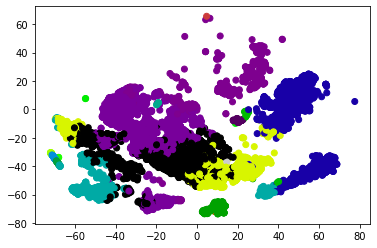

In [18]:
import matplotlib.pyplot as plt
plt.scatter(train_embedded[0:10000, 0], train_embedded[0:10000, 1], c=clusters.labels_[0:10000], cmap=plt.cm.nipy_spectral)

In [7]:
df = pd.DataFrame(info_save_list)
# df.to_csv("exp_results_{}.csv".format(dataset), index=False)
df

,linkage,F1,Recall,Precision,Anomaly_ratio
0,complete,0.886777,1.000000,0.796585,0.001000
1,complete,0.999073,0.998147,1.000000,0.006211
2,complete,0.996302,0.992631,1.000000,0.011421
3,complete,0.990988,0.982136,1.000000,0.016632
4,complete,0.982853,0.966284,1.000000,0.021842
5,complete,0.974674,0.950600,1.000000,0.027053
6,complete,0.965938,0.934119,1.000000,0.032263
7,complete,0.957696,0.918827,1.000000,0.037474
8,complete,0.951271,0.907071,1.000000,0.042684
9,complete,0.942782,0.891758,1.000000,0.047895


In [20]:
test_dist_mat.min()

0.22762597

In [80]:
df1_2

,linkage,F1,Recall,Precision,Anomaly_ratio
0,complete,0.810811,0.979112,0.691882,0.001000
1,complete,0.839928,0.819298,0.861624,0.006211
2,complete,0.767461,0.691852,0.861624,0.011421
3,complete,0.768902,0.626744,0.994465,0.016632
4,complete,0.712021,0.554527,0.994465,0.021842
5,complete,0.662569,0.496774,0.994465,0.027053
6,complete,0.619896,0.450292,0.994465,0.032263
7,complete,0.581446,0.410823,0.994465,0.037474
8,complete,0.546653,0.376923,0.994465,0.042684
9,complete,0.515789,0.348191,0.994465,0.047895
